In [1]:
!pip install mpi4py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### The non-parallel version of the integral calculation function

In [3]:
def func(x):
  return x**2 - x + 5

a, b, N = 0, 1, 1000

In [4]:
# %%timeit
def analytical_integration(a, b):
  return quad(func, a, b)[0]

In [5]:
print("Analytical result:", analytical_integration(0, 1))

Analytical result: 4.833333333333333


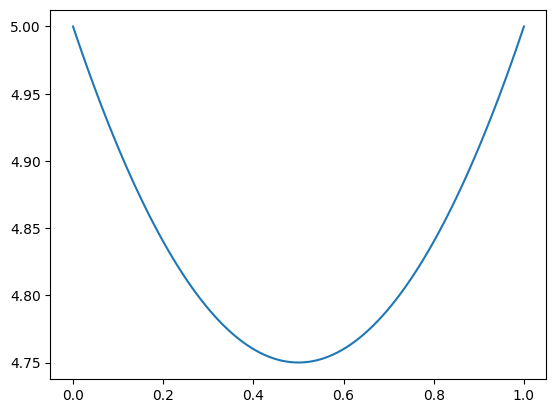

In [6]:
x = linspace(0, 1, 100)
plot(x, func(x))
show()

In [7]:
def rectangle_rule_integration(func, a, b, N):

    h = (b - a) / N
    integral = 0
    for i in range(N):
        x_left = a + i * h
        x_right = a + (i + 1) * h
        x_mid = (x_left + x_right) / 2
        integral += func(x_mid) * h
    return integral

print("Numerical approximate result:", \
      rectangle_rule_integration(func, a, b, N))

Numerical approximate result: 4.833333250000002


In [8]:
analytical_time = %timeit -o analytical_integration(a, b)
analytical_time.best

13.7 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


7.566499799997928e-06

In [9]:
numerical_time = %timeit -o rectangle_rule_integration(func, a, b, N)
numerical_time.best

The slowest run took 4.19 times longer than the fastest. This could mean that an intermediate result is being cached.
1.01 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.0005324569110000539

###Parallel MPI version using mpi4py

In [10]:
%%writefile parallel_MPI.py
from mpi4py import MPI
import numpy as np
from scipy.integrate import quad

def func(x):
    return x**2 - x + 5

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
N_points = 1000  # Number of discretization points
a, b = 0, 1 #Limits

start_time = MPI.Wtime()

# Local integrals
local_n = N_points // size
local_a = a + rank * local_n * (b - a) / N_points
local_b = local_a + local_n * (b - a) / N_points
local_integral = np.zeros(1)

#print(local_a, local_b)

x = np.linspace(local_a, local_b, local_n)
local_integral[0] = np.sum(func(x)) * (b - a) / N_points

# Sum up the local integrals
integral = np.zeros(1)
comm.Reduce(local_integral, integral, op=MPI.SUM, root=0)


end_time = MPI.Wtime()

mpi_time = end_time - start_time

if rank == 0:
    print("Numerical result:", integral[0])
    #print("Elapsed times from all processes:", mpi_time)
    print(mpi_time)

MPI.Finalize()

Overwriting parallel_MPI.py


In [11]:
!mpirun -n 4 --allow-run-as-root --oversubscribe python parallel_MPI.py

Numerical result: 4.83337516733601
0.000481988


In [12]:
_, mpi_time = !mpirun -n 2 --allow-run-as-root --oversubscribe python parallel_MPI.py

### Achieve speed up > 1.5 with 2 process parallel version vs. 1 process sequential version

In [13]:
float(mpi_time) / analytical_time.best

1156.7855985408733

### MPI check

In [14]:
num_processes = [1, 2, 4]
def mpi_check(N):
  value, mpi_time = !mpirun -n {N} --allow-run-as-root --oversubscribe python parallel_MPI.py
  return N, value

for N in num_processes:
   print(mpi_check(N))

(1, 'Numerical result: 4.833500166833501')
(2, 'Numerical result: 4.833416833667335')
(4, 'Numerical result: 4.83337516733601')


In [15]:
def mpi(N):
  _, mpi_time = !mpirun -n {N} --allow-run-as-root --oversubscribe python parallel_MPI.py
  return mpi_time


num_processes = [1, 2, 4]
parallel_time, serial_time = [], [analytical_time.best]*len(num_processes)

for N in num_processes:
    parallel_time.append(float32(mpi(N)))

speedup = [parallel / serial for parallel, serial in zip(parallel_time, serial_time)]

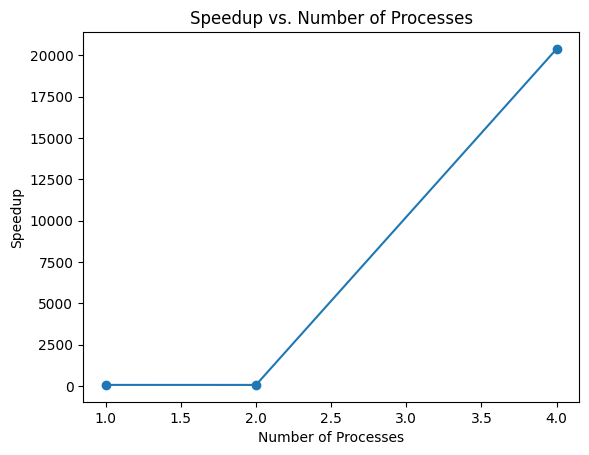

In [16]:
plot(num_processes, speedup, marker='o')
xlabel('Number of Processes')
ylabel('Speedup')
title('Speedup vs. Number of Processes')
show()